# UNet的实现
Reference https://zhuanlan.zhihu.com/p/572161541

## 定义几个基本的Function

In [56]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchsummary

In [4]:
def exists(x):
    return x is not None

# 有val时返回val，val为None时返回d
def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# 残差模块，将输入加到输出上
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# 上采样（反卷积）
def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

# 下采样
def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


## Positional embeddings

类似于Transformer的positional embedding，为了让网络知道当前处理的是一系列去噪过程中的哪一个step，我们需要将步数 $t$ 也编码并传入网络之中。

DDPM采用正弦位置编码（Sinusoidal Positional Embeddings）这一方法的输入是shape为 (batch_size, 1) 的 tensor，也就是batch中每一个sample所处的 $t$ ，并将这个tensor转换为shape为 (batch_size, dim) 的 tensor。这个tensor会被加到每一个残差模块中。

In [8]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

总之就是将 $t$ 编码为embedding，和原本的输入一起进入网络，让网络“知道”当前的输入属于哪个step。

## ResNet block

In [14]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """Deep Residual Learning for Image Recognition"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

## Attention module

两种attention模块，一个是常规的 multi-head self-attention，一个是 linear attention variant

In [17]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

## Group normalization

In [20]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

## Conditional U-Net

具体的网络结构：

1. 首先，输入通过一个卷积层，同时计算step $t$ 所对应得embedding

2. 通过一系列的下采样stage，每个stage都包含：2个ResNet blocks + groupnorm + attention + residual connection + downsample operation

3. 在网络中间，应用一个带attention的ResNet

4. 通过一系列的上采样stage，每个stage都包含：2个ResNet blocks + groupnorm + attention + residual connection + upsample operation

5. 最终，通过一个ResNet/ConvNeXT blocl和一个卷积层。


- Input：a batch of noisy images of shape ( batch_size, num_channels, h, w ) and a batch of steps of shape ( batch_size, 1 )

- output: a tensor of shape  ( batch_size, num_channels, h, w )


In [25]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)
        t = self.time_mlp(time) if exists(self.time_mlp) else None
        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

# Diffusion过程的实现
Reference https://zhuanlan.zhihu.com/p/572161541

## 首先预处理图片

#### 选择一张原始图片，并简单看看原图

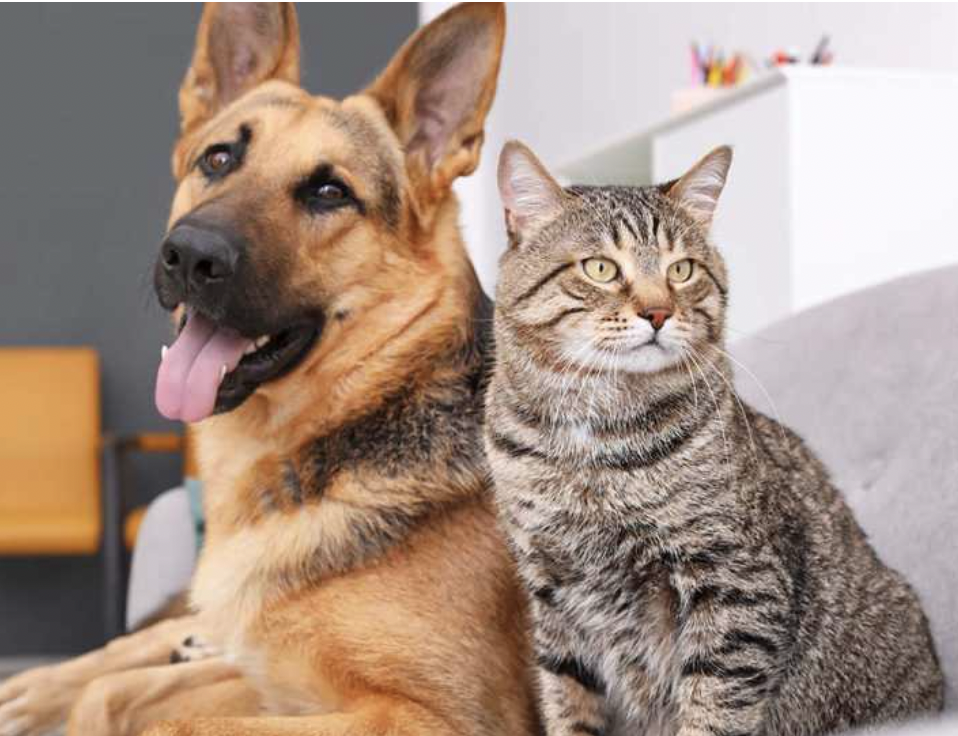

In [31]:
from PIL import Image
path = "../Yolov1/dataset/catdog.jpg"
image = Image.open(path)
image

#### 进行标准化处理

In [49]:
import albumentations

class ImagePaths(Dataset):
    def __init__(self, path, size=None):
        self.size = size

        self.images = [os.path.join(path, file) for file in os.listdir(path)]
        self._length = len(self.images)

        self.rescaler = albumentations.SmallestMaxSize(max_size=self.size)
        self.cropper = albumentations.CenterCrop(height=self.size, width=self.size)
        self.preprocessor = albumentations.Compose([self.rescaler, self.cropper])

    def __len__(self):
        return self._length

    def preprocess_image(self, image_path):
        image = Image.open(image_path)
        if not image.mode == "RGB":
            image = image.convert("RGB")
        image = np.array(image).astype(np.uint8)
        image = self.preprocessor(image=image)["image"]
        image = (image / 127.5 - 1.0).astype(np.float32)
        image = image.transpose(2, 0, 1)
        return image

    def __getitem__(self, i):
        example = self.preprocess_image(self.images[i])
        return example

def load_data(dataset_path):
    train_data = ImagePaths(dataset_path, size=256)
    train_loader = DataLoader(train_data, batch_size=2, shuffle=False)
    return train_loader

dataset_path = "../Yolov1/dataset/"
single_loader = load_data(dataset_path)
single_loader

In [57]:
single_img = iter(single_loader)
single_img.next()

tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  0.9922,  1.0000,  1.0000],
          [-0.2000, -0.2000, -0.2000,  ...,  0.8510,  0.8510,  0.8510],
          [-0.2078, -0.2000, -0.2000,  ...,  0.8510,  0.8510,  0.8510],
          ...,
          [ 0.3804,  0.2941,  0.2863,  ..., -0.2549, -0.1765, -0.0824],
          [ 0.3804,  0.3098,  0.2863,  ..., -0.2235, -0.1765, -0.0824],
          [ 0.3176,  0.2471,  0.2549,  ...,  0.0039,  0.1373,  0.1216]],

         [[ 0.9922,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1765, -0.1765, -0.1765,  ...,  0.8196,  0.8196,  0.8196],
          [-0.1765, -0.1765, -0.1765,  ...,  0.8196,  0.8196,  0.8196],
          ...,
          [ 0.0431, -0.0510, -0.0588,  ..., -0.3412, -0.2706, -0.1451],
          [ 0.0275, -0.0275, -0.0510,  ..., -0.3098, -0.2549, -0.1529],
          [-0.0353, -0.0824, -0.0902,  ..., -0.0667,  0.0745,  0.0588]],

         [[ 0.9922,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  0.9922],
          [-0.1608, -0.1686, -

## 前向扩散过程
DDPM中使用linear schedule定义 $\beta$，但[IDDPM](https://arxiv.org/abs/2102.09672)证明使用 $cosine \, schedule$ 可能会有更好的效果，下面同时定义两者并比较效果

In [29]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

将 $T$ 设置为200，并将每个 $t$ 下的各种参数提前计算好

首先使用与DDPM相同的 $linear \, schedule$

In [36]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

#### 定义前向扩散过程

In [46]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)
  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())
  return noisy_image

定义采样多个 $t$ 并且展示图片的方法

In [48]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [50]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

NameError: name 'x_start' is not defined